# Sudoku-Python-Genetic : Algorithme Genetique (Python)

**Navigation** : [<< Python OR-Tools-Z3](Sudoku-Python-ORTools-Z3.ipynb) | [Index](README.md) | [Python DancingLinks >>](Sudoku-Python-DancingLinks.ipynb)

## Objectifs d'apprentissage

A la fin de ce notebook, vous saurez :
1. Implementer un algorithme genetique avec PyGAD
2. Encoder un probleme de contraintes en chromosome
3. Comprendre pourquoi le Sudoku est difficile pour les algorithmes genetiques
4. Comparer deux strategies d'encodage : cellules vs permutations

**Duree estimee** : ~10 min | **Prerequis** : [Sudoku-0 Environment](Sudoku-0-Environment.ipynb) | **Lien** : Voir [Search-5 GeneticAlgorithms](../Search/Foundations/Search-5-GeneticAlgorithms.ipynb)

---

Ce notebook implemente un solveur de Sudoku utilisant un algorithme genetique avec PyGAD.
C'est l'equivalent Python du notebook C# `Sudoku-2-Genetic.ipynb`.

## Introduction

Les algorithmes genetiques (GA) sont des techniques d'optimisation inspirees de la selection naturelle:
1. **Population**: Ensemble de solutions candidates (chromosomes)
2. **Fitness**: Evaluation de la qualite de chaque solution
3. **Selection**: Choix des meilleurs individus pour la reproduction
4. **Croisement**: Combinaison de deux parents pour creer des enfants
5. **Mutation**: Modification aleatoire pour maintenir la diversite

**Limitation connue**: Le Sudoku est difficile pour les GA car:
- L'espace de recherche a de nombreux extrema locaux
- La densite de solutions valides est tres faible
- Les contraintes sont difficiles a satisfaire par evolution

## Installation

```bash
pip install pygad numpy matplotlib
```

In [1]:
# Imports
import numpy as np
import time
from typing import List, Tuple, Optional, Callable
import matplotlib.pyplot as plt

try:
    import pygad
    print(f"PyGAD version: {pygad.__version__}")
except ImportError:
    print("PyGAD non installe. Executez: pip install pygad")
    raise

PyGAD version: 3.5.0


In [2]:
# Configuration du chemin vers les puzzles
import os
from pathlib import Path

# Définir le chemin absolu vers le dossier Puzzles
NOTEBOOK_DIR = Path(r"D:\Dev\CoursIA\MyIA.AI.Notebooks\Sudoku")
PUZZLES_DIR = NOTEBOOK_DIR / "Puzzles"

# Vérifier que le dossier existe
if PUZZLES_DIR.exists():
    print(f"Dossier Puzzles: {PUZZLES_DIR}")
else:
    print(f"ATTENTION: Dossier Puzzles non trouvé à {PUZZLES_DIR}")
    PUZZLES_DIR = Path(os.getcwd()) / "Puzzles"

Dossier Puzzles: D:\Dev\CoursIA\MyIA.AI.Notebooks\Sudoku\Puzzles


## 1. Classe SudokuGrid

In [3]:
class SudokuGrid:
    """Representation d'une grille de Sudoku 9x9."""
    
    def __init__(self, grid: Optional[List[List[int]]] = None):
        if grid is None:
            self.cells = np.zeros((9, 9), dtype=int)
        else:
            self.cells = np.array(grid, dtype=int)
    
    @classmethod
    def from_string(cls, s: str) -> 'SudokuGrid':
        s = s.replace('.', '0').replace(' ', '').replace('\n', '')
        if len(s) != 81:
            raise ValueError(f"La chaine doit avoir 81 caracteres")
        grid = cls()
        grid.cells = np.array([int(c) for c in s], dtype=int).reshape(9, 9)
        return grid
    
    def clone(self) -> 'SudokuGrid':
        return SudokuGrid(self.cells.copy())
    
    def count_errors(self) -> int:
        """Compte le nombre total d'erreurs (doublons) dans la grille."""
        errors = 0
        
        # Erreurs par ligne
        for i in range(9):
            row = self.cells[i, :]
            row_nonzero = row[row > 0]
            errors += len(row_nonzero) - len(np.unique(row_nonzero))
        
        # Erreurs par colonne
        for j in range(9):
            col = self.cells[:, j]
            col_nonzero = col[col > 0]
            errors += len(col_nonzero) - len(np.unique(col_nonzero))
        
        # Erreurs par bloc 3x3
        for box_row in range(3):
            for box_col in range(3):
                block = self.cells[box_row*3:(box_row+1)*3, box_col*3:(box_col+1)*3].flatten()
                block_nonzero = block[block > 0]
                errors += len(block_nonzero) - len(np.unique(block_nonzero))
        
        return errors
    
    def is_solved(self) -> bool:
        """Verifie si la grille est resolue (complete et sans erreurs)."""
        if np.any(self.cells == 0):
            return False
        return self.count_errors() == 0
    
    def get_mask(self) -> np.ndarray:
        """Retourne le masque des cellules fixes (True = fixe, False = variable)."""
        return self.cells > 0
    
    def __str__(self) -> str:
        lines = []
        for r in range(9):
            if r > 0 and r % 3 == 0:
                lines.append('-' * 21)
            row_str = ''
            for c in range(9):
                if c > 0 and c % 3 == 0:
                    row_str += '| '
                val = self.cells[r, c]
                row_str += (str(val) if val != 0 else '.') + ' '
            lines.append(row_str)
        return '\n'.join(lines)

def load_puzzles(filepath: str, max_puzzles: int = None) -> List[str]:
    puzzles = []
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if len(line) >= 81:
                puzzles.append(line[:81])
                if max_puzzles and len(puzzles) >= max_puzzles:
                    break
    return puzzles

# Charger puzzles
easy_puzzles = load_puzzles(str(PUZZLES_DIR / 'Sudoku_Easy51.txt'), max_puzzles=5)
print(f"Puzzles charges: {len(easy_puzzles)}")

# Test
test_grid = SudokuGrid.from_string(easy_puzzles[0])
print("\nGrille de test:")
print(test_grid)
print(f"\nErreurs initiales: {test_grid.count_errors()}")

Puzzles charges: 5

Grille de test:
9 . 2 | . . 5 | 4 . 3 
1 . . | . 6 3 | . 2 5 
5 . 8 | 4 . 7 | . 6 . 
---------------------
. 2 6 | 3 . 9 | . . 1 
. 5 7 | . 1 . | 2 9 . 
. 9 . | 6 7 . | 5 3 . 
---------------------
2 4 . | 5 3 . | 6 . . 
7 . 5 | 2 . . | 3 . 4 
. 8 . | . 4 1 | 9 5 . 

Erreurs initiales: 0


## 2. Approche 1: Chromosome par Cellules

Chaque gene represente une cellule (valeur 1-9).
Simple mais inefficace car les contraintes de lignes/colonnes ne sont pas respectees.

In [4]:
class CellsGeneticSolver:
    """Solveur genetique avec chromosome par cellules."""
    
    def __init__(self, num_generations: int = 500, population_size: int = 200):
        self.num_generations = num_generations
        self.population_size = population_size
        self.best_fitness_history = []
    
    def solve(self, puzzle: SudokuGrid) -> Tuple[SudokuGrid, bool]:
        """Resout le Sudoku avec algorithme genetique."""
        self.puzzle = puzzle
        self.mask = puzzle.get_mask().flatten()  # Cellules fixes
        self.fixed_values = puzzle.cells.flatten()  # Valeurs initiales
        self.best_fitness_history = []
        
        # Nombre de genes = cellules variables seulement
        self.variable_indices = np.where(~self.mask)[0]
        num_genes = len(self.variable_indices)
        
        if num_genes == 0:
            return puzzle.clone(), puzzle.is_solved()
        
        def fitness_func(ga_instance, solution, solution_idx):
            grid = self._solution_to_grid(solution)
            errors = grid.count_errors()
            # Fitness negative (PyGAD maximise)
            return -errors
        
        def on_generation(ga_instance):
            best = ga_instance.best_solution()[1]
            self.best_fitness_history.append(-best)  # Convertir en erreurs
        
        ga = pygad.GA(
            num_generations=self.num_generations,
            num_parents_mating=self.population_size // 4,
            fitness_func=fitness_func,
            sol_per_pop=self.population_size,
            num_genes=num_genes,
            gene_type=int,
            init_range_low=1,
            init_range_high=10,  # [1, 10) = 1-9
            gene_space=list(range(1, 10)),
            parent_selection_type="tournament",
            crossover_type="two_points",
            mutation_type="random",
            mutation_percent_genes=10,
            on_generation=on_generation,
            stop_criteria="reach_0",  # Arreter si fitness = 0 (0 erreurs)
            suppress_warnings=True
        )
        
        ga.run()
        
        solution, fitness, _ = ga.best_solution()
        result_grid = self._solution_to_grid(solution)
        
        return result_grid, result_grid.is_solved()
    
    def _solution_to_grid(self, solution: np.ndarray) -> SudokuGrid:
        """Convertit une solution GA en grille Sudoku."""
        cells = self.fixed_values.copy()
        cells[self.variable_indices] = solution.astype(int)
        grid = SudokuGrid()
        grid.cells = cells.reshape(9, 9)
        return grid

# Test
print("=== Test Chromosome par Cellules ===")
solver = CellsGeneticSolver(num_generations=200, population_size=100)
test_grid = SudokuGrid.from_string(easy_puzzles[0])

print(f"Puzzle initial ({81 - np.sum(test_grid.get_mask())} cellules vides):")
print(test_grid)

start = time.time()
result, solved = solver.solve(test_grid)
elapsed = time.time() - start

print(f"\nResolu: {solved}")
print(f"Erreurs finales: {result.count_errors()}")
print(f"Temps: {elapsed:.2f}s")
print(f"Generations: {len(solver.best_fitness_history)}")
print("\nResultat:")
print(result)

=== Test Chromosome par Cellules ===
Puzzle initial (36 cellules vides):
9 . 2 | . . 5 | 4 . 3 
1 . . | . 6 3 | . 2 5 
5 . 8 | 4 . 7 | . 6 . 
---------------------
. 2 6 | 3 . 9 | . . 1 
. 5 7 | . 1 . | 2 9 . 
. 9 . | 6 7 . | 5 3 . 
---------------------
2 4 . | 5 3 . | 6 . . 
7 . 5 | 2 . . | 3 . 4 
. 8 . | . 4 1 | 9 5 . 



Resolu: False
Erreurs finales: 19
Temps: 8.61s
Generations: 200

Resultat:
9 6 2 | 5 3 5 | 4 1 3 
1 7 4 | 9 6 3 | 8 2 5 
5 9 8 | 4 8 7 | 7 6 9 
---------------------
8 2 6 | 3 5 9 | 7 4 1 
3 5 7 | 8 1 4 | 2 9 7 
4 9 1 | 6 7 2 | 5 3 6 
---------------------
2 4 9 | 5 3 6 | 6 7 8 
7 1 5 | 2 9 6 | 3 8 4 
6 8 3 | 7 4 1 | 9 5 2 


## 3. Approche 2: Chromosome par Permutations de Lignes

Chaque gene represente une permutation complete d'une ligne.
Plus efficace car les contraintes de lignes sont automatiquement satisfaites.

In [5]:
from itertools import permutations

class PermutationGeneticSolver:
    """Solveur genetique avec chromosome par permutations de lignes."""
    
    def __init__(self, num_generations: int = 500, population_size: int = 200):
        self.num_generations = num_generations
        self.population_size = population_size
        self.best_fitness_history = []
    
    def solve(self, puzzle: SudokuGrid) -> Tuple[SudokuGrid, bool]:
        self.puzzle = puzzle
        self.best_fitness_history = []
        
        # Precalculer les permutations valides pour chaque ligne
        self.valid_perms = self._compute_valid_permutations(puzzle)
        
        # Verifier qu'il y a des permutations valides
        for i, perms in enumerate(self.valid_perms):
            if len(perms) == 0:
                print(f"Erreur: Ligne {i} n'a aucune permutation valide!")
                return puzzle.clone(), False
            print(f"Ligne {i}: {len(perms)} permutations valides")
        
        def fitness_func(ga_instance, solution, solution_idx):
            grid = self._solution_to_grid(solution)
            # Compter erreurs colonnes et blocs seulement (lignes OK par construction)
            errors = self._count_column_block_errors(grid)
            return -errors
        
        def on_generation(ga_instance):
            best = ga_instance.best_solution()[1]
            self.best_fitness_history.append(-best)
        
        # Gene space: index dans les permutations valides de chaque ligne
        gene_space = [list(range(len(perms))) for perms in self.valid_perms]
        
        ga = pygad.GA(
            num_generations=self.num_generations,
            num_parents_mating=self.population_size // 4,
            fitness_func=fitness_func,
            sol_per_pop=self.population_size,
            num_genes=9,  # 9 lignes
            gene_type=int,
            gene_space=gene_space,
            parent_selection_type="tournament",
            crossover_type="single_point",
            mutation_type="random",
            mutation_percent_genes=20,
            on_generation=on_generation,
            stop_criteria="reach_0",
            suppress_warnings=True
        )
        
        ga.run()
        
        solution, fitness, _ = ga.best_solution()
        result_grid = self._solution_to_grid(solution)
        
        return result_grid, result_grid.is_solved()
    
    def _compute_valid_permutations(self, puzzle: SudokuGrid) -> List[List[Tuple]]:
        """Calcule les permutations valides pour chaque ligne."""
        valid_perms = []
        all_digits = set(range(1, 10))
        
        for row in range(9):
            row_data = puzzle.cells[row, :]
            fixed_positions = {col: val for col, val in enumerate(row_data) if val != 0}
            fixed_values = set(fixed_positions.values())
            missing_values = list(all_digits - fixed_values)
            empty_positions = [col for col in range(9) if row_data[col] == 0]
            
            # Generer permutations des valeurs manquantes
            row_perms = []
            for perm in permutations(missing_values):
                # Construire la ligne complete
                full_row = list(row_data)
                for i, pos in enumerate(empty_positions):
                    full_row[pos] = perm[i]
                row_perms.append(tuple(full_row))
            
            # Limiter le nombre de permutations (pour performance)
            if len(row_perms) > 5000:
                np.random.shuffle(row_perms)
                row_perms = row_perms[:5000]
            
            valid_perms.append(row_perms)
        
        return valid_perms
    
    def _solution_to_grid(self, solution: np.ndarray) -> SudokuGrid:
        """Convertit indices de permutations en grille."""
        grid = SudokuGrid()
        for row in range(9):
            perm_idx = int(solution[row])
            perm_idx = min(perm_idx, len(self.valid_perms[row]) - 1)  # Securite
            grid.cells[row, :] = self.valid_perms[row][perm_idx]
        return grid
    
    def _count_column_block_errors(self, grid: SudokuGrid) -> int:
        """Compte erreurs colonnes et blocs (lignes OK par construction)."""
        errors = 0
        
        # Colonnes
        for j in range(9):
            col = grid.cells[:, j]
            errors += 9 - len(np.unique(col))
        
        # Blocs 3x3
        for box_row in range(3):
            for box_col in range(3):
                block = grid.cells[box_row*3:(box_row+1)*3, box_col*3:(box_col+1)*3].flatten()
                errors += 9 - len(np.unique(block))
        
        return errors

# Test
print("\n=== Test Chromosome par Permutations ===")
solver = PermutationGeneticSolver(num_generations=300, population_size=200)
test_grid = SudokuGrid.from_string(easy_puzzles[0])

print(f"\nPuzzle initial:")
print(test_grid)

start = time.time()
result, solved = solver.solve(test_grid)
elapsed = time.time() - start

print(f"\nResolu: {solved}")
print(f"Erreurs finales: {result.count_errors()}")
print(f"Temps: {elapsed:.2f}s")
print(f"Generations: {len(solver.best_fitness_history)}")
print("\nResultat:")
print(result)


=== Test Chromosome par Permutations ===

Puzzle initial:
9 . 2 | . . 5 | 4 . 3 
1 . . | . 6 3 | . 2 5 
5 . 8 | 4 . 7 | . 6 . 
---------------------
. 2 6 | 3 . 9 | . . 1 
. 5 7 | . 1 . | 2 9 . 
. 9 . | 6 7 . | 5 3 . 
---------------------
2 4 . | 5 3 . | 6 . . 
7 . 5 | 2 . . | 3 . 4 
. 8 . | . 4 1 | 9 5 . 
Ligne 0: 24 permutations valides
Ligne 1: 24 permutations valides
Ligne 2: 24 permutations valides
Ligne 3: 24 permutations valides
Ligne 4: 24 permutations valides
Ligne 5: 24 permutations valides
Ligne 6: 24 permutations valides
Ligne 7: 24 permutations valides
Ligne 8: 24 permutations valides



Resolu: True
Erreurs finales: 0
Temps: 2.79s
Generations: 33

Resultat:
9 6 2 | 1 8 5 | 4 7 3 
1 7 4 | 9 6 3 | 8 2 5 
5 3 8 | 4 2 7 | 1 6 9 
---------------------
8 2 6 | 3 5 9 | 7 4 1 
3 5 7 | 8 1 4 | 2 9 6 
4 9 1 | 6 7 2 | 5 3 8 
---------------------
2 4 9 | 5 3 8 | 6 1 7 
7 1 5 | 2 9 6 | 3 8 4 
6 8 3 | 7 4 1 | 9 5 2 


## 4. Visualisation de la Convergence

=== Comparaison des approches ===

--- Approche Cellules ---


Resolu: False, Erreurs: 18, Temps: 20.71s

--- Approche Permutations ---
Ligne 0: 24 permutations valides
Ligne 1: 24 permutations valides
Ligne 2: 24 permutations valides
Ligne 3: 24 permutations valides
Ligne 4: 24 permutations valides
Ligne 5: 24 permutations valides
Ligne 6: 24 permutations valides
Ligne 7: 24 permutations valides
Ligne 8: 24 permutations valides


Resolu: True, Erreurs: 0, Temps: 1.08s


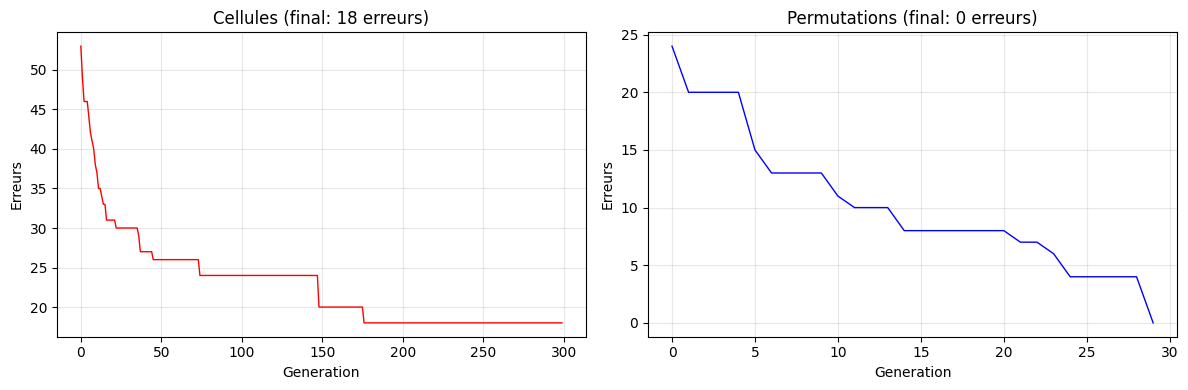

In [6]:
def plot_convergence(fitness_history: List[int], title: str = "Convergence"):
    """Affiche la courbe de convergence."""
    plt.figure(figsize=(10, 4))
    plt.plot(fitness_history, 'b-', linewidth=1)
    plt.xlabel('Generation')
    plt.ylabel('Nombre d\'erreurs')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Comparaison des deux approches
print("=== Comparaison des approches ===")

test_grid = SudokuGrid.from_string(easy_puzzles[0])

# Approche 1: Cellules
print("\n--- Approche Cellules ---")
solver1 = CellsGeneticSolver(num_generations=300, population_size=150)
start = time.time()
result1, solved1 = solver1.solve(test_grid.clone())
time1 = time.time() - start
print(f"Resolu: {solved1}, Erreurs: {result1.count_errors()}, Temps: {time1:.2f}s")

# Approche 2: Permutations
print("\n--- Approche Permutations ---")
solver2 = PermutationGeneticSolver(num_generations=300, population_size=150)
start = time.time()
result2, solved2 = solver2.solve(test_grid.clone())
time2 = time.time() - start
print(f"Resolu: {solved2}, Erreurs: {result2.count_errors()}, Temps: {time2:.2f}s")

# Graphiques
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(solver1.best_fitness_history, 'r-', linewidth=1)
axes[0].set_title(f'Cellules (final: {result1.count_errors()} erreurs)')
axes[0].set_xlabel('Generation')
axes[0].set_ylabel('Erreurs')
axes[0].grid(True, alpha=0.3)

axes[1].plot(solver2.best_fitness_history, 'b-', linewidth=1)
axes[1].set_title(f'Permutations (final: {result2.count_errors()} erreurs)')
axes[1].set_xlabel('Generation')
axes[1].set_ylabel('Erreurs')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Test sur Plusieurs Puzzles

In [7]:
def benchmark_genetic(puzzles: List[str], solver_class, solver_kwargs: dict, name: str):
    """Benchmark un solveur genetique sur plusieurs puzzles."""
    print(f"\n=== Benchmark: {name} ({len(puzzles)} puzzles) ===")
    
    results = []
    total_time = 0
    solved_count = 0
    
    for i, puzzle_str in enumerate(puzzles):
        grid = SudokuGrid.from_string(puzzle_str)
        solver = solver_class(**solver_kwargs)
        
        start = time.time()
        result, solved = solver.solve(grid)
        elapsed = time.time() - start
        
        errors = result.count_errors()
        total_time += elapsed
        if solved:
            solved_count += 1
        
        status = "OK" if solved else f"{errors} err"
        print(f"  Puzzle {i+1}: {status}, {elapsed:.2f}s, {len(solver.best_fitness_history)} gen")
        results.append({'solved': solved, 'errors': errors, 'time': elapsed})
    
    print(f"\nResume:")
    print(f"  Resolus: {solved_count}/{len(puzzles)}")
    print(f"  Temps total: {total_time:.2f}s")
    print(f"  Temps moyen: {total_time/len(puzzles):.2f}s")
    
    return results

# Benchmark avec quelques puzzles faciles
benchmark_genetic(
    easy_puzzles[:3],
    PermutationGeneticSolver,
    {'num_generations': 500, 'population_size': 200},
    "Permutations - Puzzles Faciles"
)


=== Benchmark: Permutations - Puzzles Faciles (3 puzzles) ===
Ligne 0: 24 permutations valides
Ligne 1: 24 permutations valides
Ligne 2: 24 permutations valides
Ligne 3: 24 permutations valides
Ligne 4: 24 permutations valides
Ligne 5: 24 permutations valides
Ligne 6: 24 permutations valides
Ligne 7: 24 permutations valides
Ligne 8: 24 permutations valides


  Puzzle 1: OK, 1.70s, 41 gen
Ligne 0: 720 permutations valides
Ligne 1: 120 permutations valides
Ligne 2: 120 permutations valides
Ligne 3: 120 permutations valides
Ligne 4: 5000 permutations valides
Ligne 5: 120 permutations valides
Ligne 6: 120 permutations valides
Ligne 7: 120 permutations valides
Ligne 8: 720 permutations valides


  Puzzle 2: 3 err, 27.55s, 500 gen


Ligne 0: 720 permutations valides
Ligne 1: 120 permutations valides
Ligne 2: 120 permutations valides
Ligne 3: 120 permutations valides
Ligne 4: 5000 permutations valides
Ligne 5: 120 permutations valides
Ligne 6: 120 permutations valides
Ligne 7: 120 permutations valides
Ligne 8: 720 permutations valides


  Puzzle 3: 8 err, 29.77s, 500 gen

Resume:
  Resolus: 1/3
  Temps total: 59.01s
  Temps moyen: 19.67s


[{'solved': True, 'errors': 0, 'time': 1.697655439376831},
 {'solved': False, 'errors': 3, 'time': 27.545262098312378},
 {'solved': False, 'errors': 8, 'time': 29.771615266799927}]

## 6. Conclusion

### Resultats

| Approche | Avantages | Inconvenients |
|----------|-----------|---------------|
| **Cellules** | Simple | Tres inefficace, contraintes non respectees |
| **Permutations** | Lignes toujours valides | Meilleur mais convergence limitee |

### Limitations des GA pour Sudoku

Les algorithmes genetiques ne sont **pas adaptes** au Sudoku car:
1. **Extrema locaux**: L'espace de recherche a de nombreux puits dont il est difficile de sortir
2. **Contraintes strictes**: Le Sudoku exige une solution exacte, pas une approximation
3. **Faible densite**: Tres peu de solutions valides parmi toutes les combinaisons

### Alternatives recommandees

Pour resoudre efficacement le Sudoku, preferez:
- **Backtracking avec MRV**: [Sudoku-Python-Backtracking.ipynb](Sudoku-Python-Backtracking.ipynb)
- **OR-Tools CP-SAT**: [Sudoku-Python-ORTools-Z3.ipynb](Sudoku-Python-ORTools-Z3.ipynb)
- **Z3 SMT**: [Sudoku-Python-ORTools-Z3.ipynb](Sudoku-Python-ORTools-Z3.ipynb)

Ces methodes garantissent de trouver une solution (si elle existe) en un temps raisonnable.

## Navigation

- **Notebook C# equivalent**: [Sudoku-2-Genetic.ipynb](Sudoku-2-Genetic.ipynb)
- **Precedent**: [Sudoku-Python-Backtracking.ipynb](Sudoku-Python-Backtracking.ipynb)
- **Suivant**: [Sudoku-Python-ORTools-Z3.ipynb](Sudoku-Python-ORTools-Z3.ipynb)

---
**Navigation** : [<< Python OR-Tools-Z3](Sudoku-Python-ORTools-Z3.ipynb) | [Index](README.md) | [Python DancingLinks >>](Sudoku-Python-DancingLinks.ipynb)